## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with the nuisance parameter bias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.estimators.map.core import DEFAULT_UNIT, FluxMaps
from gammapy.modeling.models.spectral import scale_plot_flux
import json
from labellines import labelLine, labelLines
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../../../')
import Dataset_load 
from scipy.interpolate import interp2d

from  Dataset_Setup import Setup, GaussianCovariance_matrix


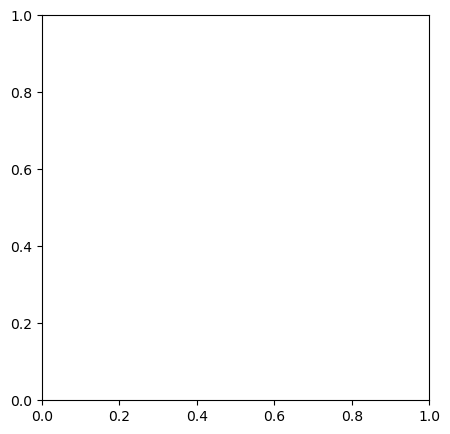

In [2]:
%matplotlib inline
savefig = 1
picformat = "png"
fig, a_fake = plt.subplots(1, 1, figsize=(5.0, 5.0))

## Methods


In [3]:
def compute_fraction(Ls_new, x_new, y_new, threshold, plot=False):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    inside = Ls_new * (Ls_new >= offset)
    fraction_inside = np.sum(inside) / tot_int
    if plot:
        fig, ax = plt.subplots(
            1,
            1,
        )
        im = ax.pcolormesh(x_new, y_new, Ls_new)
        fig.colorbar(im)
        ax.set_title(f"frac inside : {fraction_inside * 100:.4} %")

        ax.contour(
            x_new, y_new, Ls_new, colors=("gold",), levels=[Ls_new.min() + threshold]
        )
    return fraction_inside

def plot_contour(ax, x_new, y_new, Ls_new, color = 'red', threshold = 1, linestyle = 'solid'):
    CS = ax.contour(
        x_new, y_new, Ls_new, colors=(color,), levels=[Ls_new.min() + threshold],
        linestyle = linestyle,
    )
    return CS

def plot_L(
    Ls_new,
    x_new,
    y_new,
    threshold,
    find_min,
    color="red",
    ax=None,
    fig=None,
    cbar=True,
    cmap="viridis",
):
    index_min, index_max, ampli_min, ampli_max, index_best, ampli_best = compute_errors(
        Ls_new, x_new, y_new, threshold, find_min=find_min
    )
    if ax is None:
        fig, ax = plt.subplots(
            1,
            1,
        )

    im = ax.pcolormesh(x_new, y_new, Ls_new, cmap=cmap, rasterized=True)
    if cbar:
        fig.colorbar(im)

    CS= plot_contour(ax, x_new, y_new, Ls_new, color = color,  threshold = threshold)
    # ax.clabel(CS, CS.levels, inline=True, fmt='$1\\sigma$', fontsize=12)

    plot_errors(
        ax,
        x_new,
        y_new,
        index_min,
        index_max,
        ampli_min,
        ampli_max,
        index_best,
        ampli_best,
        color,
    )

    ax.plot(ampli_best, index_best, "x", color=color)

    ax.set_ylabel(f"Amplitude [{a_unit}]")
    ax.set_xlabel("Index []")
    return CS


def plot_errors(
    ax,
    x_new,
    y_new,
    index_min,
    index_max,
    ampli_min,
    ampli_max,
    index_best,
    ampli_best,
    color,
):
    linewidth = 2

    ax.hlines(
        y=index_min,
        xmin=x_new[0],
        xmax=x_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )
    ax.hlines(
        y=index_max,
        xmin=x_new[0],
        xmax=x_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )

    ax.vlines(
        x=ampli_min,
        ymin=y_new[0],
        ymax=y_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )
    ax.vlines(
        x=ampli_max,
        ymin=y_new[0],
        ymax=y_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )


def compute_errors(Ls_new, x_new, y_new, threshold, find_min):
    offset = Ls_new.min() + threshold
    if offset > 0:
        inside = Ls_new * (Ls_new < offset)
    else:
        inside = Ls_new * (Ls_new >= offset)
    if find_min:  # find min:
        pos = np.where(inside > 0)
        ampli_best = x_new[np.where(Ls_new == Ls_new.min())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.min())[0][0]]

    else:  # find max
        pos = np.where(inside > 0)
        ampli_best = x_new[np.where(Ls_new == Ls_new.max())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.max())[0][0]]

    delta_bin = (x_new[1] - x_new[0]) / 2
    ampli_min = x_new[np.min(pos[1])] - delta_bin
    ampli_max = x_new[np.max(pos[1])] + delta_bin
    ampli_best += delta_bin

    delta_bin = (y_new[1] - y_new[0]) / 2
    index_min = y_new[np.min(pos[0])] - delta_bin
    index_max = y_new[np.max(pos[0])] + delta_bin
    index_best += delta_bin

    return index_min, index_max, ampli_min, ampli_max, index_best, ampli_best


def fraction_within(lower_lim, upper_lim, data):
    is_within = []
    for d in data:
        larger = np.all(d[0] >= lower_lim)
        smaller = np.all(d[0] <= upper_lim)
        is_within.append(larger and smaller)

    return np.count_nonzero(is_within) / len(data)

In [4]:
def plot_amplitude(axs_a):
    # ampli
    a = axs_a
    i = 1
    a.hist(
        valuies[i][1:, 0],
        color=color_rnd,
        alpha=0.8,
        bins=np.linspace(xlims[i][0], xlims[i][-1], nbins),
        orientation="horizontal",
    )

    a.hist(
        valuies_N[i][1:, 0],
        color=color_rnd_nui,
        alpha=0.8,
        bins=np.linspace(xlims[i][0], xlims[i][-1], nbins),
        orientation="horizontal",
    )

    ylim = a.get_xlim()
    delta_ylim = 5
    a.hlines(
        valuies_asimov_N[i][0],
        ylim[0],
        ylim[1] + delta_ylim,
        color=colors[1],
        linestyle="dashed",
    )
    a.fill_betweenx(
        [
            valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
            valuies_asimov_N[i][0] + valuies_asimov_N[i][1],
        ],
        ylim[0],
        ylim[1] + delta_ylim,
        alpha=alpha_nui,
        color=colors[3],
        label=legends[0] + f"{withins[i][1]*100 :.3}\\%",
    )
    a.hlines(valuies_asimov[i][0], ylim[0], ylim[1], color=colors[0])
    a.fill_betweenx(
        [
            valuies_asimov[i][0] - valuies_asimov[i][1],
            valuies_asimov[i][0] + valuies_asimov[i][1],
        ],
        ylim[0],
        ylim[1],
        alpha=alpha_st,
        color=colors[2],
        label=legends[1] + f"{withins[i][0]*100 :.3}\\%",
    )
    a.set_xlabel("")
    a.set_ylim(axs_L.get_ylim()[0], axs_L.get_ylim()[1])
    yy = a.get_xlim()[1]
    print(
        f"amplitudes  : {np.mean(amplitudes[:,0]):.5} pm {np.std(amplitudes[:,0]):.5}"
    )
    print(
        f"amplitudes N: {np.mean(amplitudes_N[:,0]):.5} pm {np.std(amplitudes_N[:,0]):.5}"
    )

    a.errorbar(
        x=yy / 3,
        y=np.mean(amplitudes[:, 0]),
        yerr=np.std(amplitudes[:, 0]),
        fmt="o",
        color=color_rnd_err,
        label="",
    )

    a.errorbar(
        x=yy / 3 - y2,
        y=np.mean(amplitudes_N[:, 0]),
        yerr=np.std(amplitudes_N[:, 0]),
        fmt="o",
        color=color_rnd_nui_err,
        label="",
    )

    a.set_yticklabels([])
    a.set_yticks([])


def plot_index(axs_i):
    # index
    a = axs_i
    i = 2
    a.hist(
        valuies[i][1:, 0],
        color=color_rnd,
        alpha=0.8,
        bins=np.linspace(xlims[i][0], xlims[i][-1], nbins),
    )
    a.hist(
        valuies_N[i][1:, 0],
        color=color_rnd_nui,
        alpha=0.8,
        bins=np.linspace(xlims[i][0], xlims[i][-1], nbins),
    )
    ylim = a.get_ylim()
    delta_ylim = 5
    a.vlines(
        valuies_asimov_N[i][0],
        ylim[0],
        ylim[1] + delta_ylim,
        color=colors[1],
        linestyle="dashed",
    )
    a.fill_between(
        [
            valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
            valuies_asimov_N[i][0] + valuies_asimov_N[i][1],
        ],
        ylim[0],
        ylim[1] + delta_ylim,
        alpha=alpha_nui,
        color=colors[3],
        label=legends[0] + f"{withins[i][1]*100 :.3}\\%",
    )
    a.vlines(valuies_asimov[i][0], ylim[0], ylim[1], color=colors[0])
    a.fill_between(
        [
            valuies_asimov[i][0] - valuies_asimov[i][1],
            valuies_asimov[i][0] + valuies_asimov[i][1],
        ],
        ylim[0],
        ylim[1],
        alpha=alpha_st,
        color=colors[2],
        label=legends[1] + f"{withins[i][0]*100 :.3}\\%",
    )
    a.set_xlabel(xlabels[i])
    yy = a.get_ylim()[1]
    print(f"index     : {np.mean(indices[:,0]):.5} pm {np.std(indices[:,0]):.5}")
    print(f"index nui : {np.mean(indices_N[:,0]):.5} pm {np.std(indices_N[:,0]):.5}")
    a.errorbar(
        x=np.mean(indices[:, 0]),
        y=yy / 3,
        xerr=np.std(indices[:, 0]),
        fmt="o",
        color=color_rnd_err,
        label="",
    )
    a.errorbar(
        x=np.mean(indices_N[:, 0]),
        y=yy / 3 - y2,
        xerr=np.std(indices_N[:, 0]),
        fmt="o",
        color=color_rnd_nui_err,
        label="",
    )
    a.set_xlim(axs_L.get_xlim()[0], axs_L.get_xlim()[1])
    a.set_xlabel("")
    a.set_xticklabels([])
    a.set_xticks([])


def plot_randoms(axs_L, fig):
   
    try:
        (
            ampli_min_asimov_N,
            ampli_max_asimov_N,
            index_min_asimov_N,
            index_max_asimov_N,
            ampli_best_asimov_N,
            index_best_asimov_N,
        ) = compute_errors(
            data_contour_N, indexy__new_N, amplix__new_N, threshold_contour, find_min=True
        )
        CS_N = plot_L(
            data_contour_N,
            indexy__new_N,
            amplix__new_N,
            threshold_contour,
            find_min=True,
            color=colors[1],
            ax=a_fake,
            fig=fig,
            cbar=False,
            cmap=cmap,
        )
        dat_N = CS_N.allsegs[0][0]
        axs_L.plot(dat_N[:, 0], dat_N[:, 1], color=colors[1])
    except:
        print("no nui")

    CS = plot_L(
        data_contour,
        indexy__new,
        amplix__new,
        threshold_contour,
        find_min=True,
        color=colors[1],
        ax=a_fake,
        fig=fig,
        cbar=False,
        cmap=cmap,
    )
    dat = CS.allsegs[0][0]
    axs_L.plot(dat[:, 0], dat[:, 1], color=colors[0])
    # axs_L.plot(index_best_asimov, ampli_best_asimov, "x", color=colors[0])

    axs_L.scatter(
        indices_data_N,
        amplitudes_data_N,
        marker=".",
        color=color_rnd_nui,
        alpha=alpha_rnd_nui,
        label="Rnd with nui.",
    )
    axs_L.scatter(
        indices_data,
        amplitudes_data,
        marker="x",
        s=14,
        color=color_rnd,
        alpha=alpha_rnd,
        label="Rnd w/o nui.",
    )

    model = fluxpoints_ds.models[0]
    ampli, index = model.parameters["amplitude"].value, model.parameters["index"].value
    ampli_err, index_err = (
        model.parameters["amplitude"].error,
        model.parameters["index"].error,
    )
    axs_L.errorbar(
        index,
        ampli,
        xerr=index_err,
        yerr=ampli_err,
        marker="x",
        markersize=6,
        color=color_rnd_example,
        alpha=0.99,
        label="Example w/o nui.",
        capsize = 5
    )

    model = fluxpoints_Nds.models[0]
    ampli, index = model.parameters["amplitude"].value, model.parameters["index"].value
    ampli_err, index_err = (
        model.parameters["amplitude"].error,
        model.parameters["index"].error,
    )

    axs_L.errorbar(
        index,
        ampli,
        xerr=index_err,
        yerr=ampli_err,
        marker="o",
        markersize=6,
        color=color_rnd_nui_example,
        alpha=0.99,
        label="Example with nui.",
        capsize = 5
    )

    axs_L.plot(2.3, 1e-12, "^", markersize=6, color="black", label="Input")
    axs_L.plot(2.3, 1e-12, "x", markersize=8, color=colors[1], label=legendsscatter[1])
    axs_L.plot(2.3, 1e-12, "+", markersize=10, color=colors[0], label=legendsscatter[0])

    off = 1e-14
    axs_L.text(
        index_best_asimov_N,
        off + ampli_max_asimov_N,
        "$1\\sigma$",
        color=colors[1],
        fontsize="x-large",
    )
    axs_L.text(
        index_best_asimov_N,
        off + ampli_max_asimov,
        "$1\\sigma$",
        color=colors[0],
        fontsize="x-large",
    )
    axs_L.plot(
        [np.nan, np.nan],
        [np.nan, np.nan],
        alpha=1,
        color=colors[0],
        label=legends[0],
    )  # + f'{fraction_N:.3}\\%')
    axs_L.plot(
        [np.nan, np.nan],
        [np.nan, np.nan],
        alpha=1,
        color=colors[1],
        label=legends[1],
    )  # +  f'{fraction:.3}\\%'  )
    axs_L.legend(ncol=2)
    axs_L.set_xlabel("Index []")
    axs_L.set_ylabel("Amplitude [1/cm2 s TeV]")

    # plt.tight_layout()
    if savefig:
        fig.savefig(f"plots/7c_L_contour_{shift}_dist_TS_nui." + picformat)
        fig.savefig(f"plots/7c_L_contour_{shift}_dist_TS_nui." + "png")
    print(N)
    return fig

def plot_fp(fp, ax=None, sed_type='dnde', energy_power=2,xerr = False, **kwargs):
    """Plot flux points.

    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        Axis object to plot on.
    sed_type : {"dnde", "flux", "eflux", "e2dnde"}
        Sed type
    energy_power : float
        Power of energy to multiply flux axis with
    **kwargs : dict
        Keyword arguments passed to `~RegionNDMap.plot`

    Returns
    -------
    ax : `~matplotlib.axes.Axes`
        Axis object
    """
    if sed_type is None:
        sed_type = fp.sed_type_plot_default

    if not fp.norm.geom.is_region:
        raise ValueError("Plotting only supported for region based flux points")

    if ax is None:
        ax = plt.gca()

    flux_unit = DEFAULT_UNIT[sed_type]

    flux = getattr(fp, sed_type)

    # get errors and ul
    y_errn, y_errp = fp._plot_get_flux_err(sed_type=sed_type)
    x_errp = 0
    is_ul = fp.is_ul.data

    if fp.has_ul and y_errn and is_ul.any():
        flux_ul = getattr(fp, sed_type + "_ul").quantity
        y_errn.data[is_ul] = np.clip(
            0.5 * flux_ul[is_ul].to_value(y_errn.unit), 0, np.inf
        )
        y_errp.data[is_ul] = 0
        flux.data[is_ul] = flux_ul[is_ul].to_value(flux.unit)
        kwargs.setdefault("uplims", is_ul)

    # set flux points plotting defaults
    if y_errp and y_errn:
        y_errp = np.clip(
            scale_plot_flux(y_errp, energy_power=energy_power).quantity, 0, np.inf
        )
        y_errn = np.clip(
            scale_plot_flux(y_errn, energy_power=energy_power).quantity, 0, np.inf
        )
        kwargs.setdefault("yerr", (y_errn, y_errp))
    else:
        kwargs.setdefault("yerr", None)
    
    if xerr == False :
        kwargs.setdefault("xerr", None)

    flux = scale_plot_flux(flux=flux.to_unit(flux_unit), energy_power=energy_power)
    ax = flux.plot(ax=ax, **kwargs)
    ax.set_ylabel(f"{sed_type} [{ax.yaxis.units}]")
    ax.set_yscale("log")
    return ax

def plot_choice_sed(fig, ax):
    plot_fp( fluxpoints_Nds.data,
           ax=ax,
        color=color_rnd_nui_example,
        label="",
        marker="x",
         capsize = 5,)
    plot_fp( fluxpoints_Nds.data,
             xerr = True,
               ax=ax,
            color=color_rnd_nui_example,
            label="SED with nui.",
            marker="x",
             )
    plot_fp(fluxpoints_ds.data,
        energy_power=2,
        ax=ax,
        color=color_rnd_example,
        label="",
        marker="x",
         capsize = 5,
    )
    plot_fp(fluxpoints_ds.data,
        energy_power=2,
        ax=ax,
        xerr = True,
        color=color_rnd_example,
        label="SED w/0 nui.",
        marker="x",
    )


    model = fluxpoints_ds.models[0]
    info = f"$\\phi_0$={model.parameters['amplitude'].value:.2} $\\pm$"
    info += f"{model.parameters['amplitude'].error:.2}\n  {model.parameters['amplitude'].unit}"
    info += f"\n$\\Gamma$={model.parameters['index'].value:.2} $\\pm$"
    info += f"{model.parameters['index'].error:.2}  {model.parameters['index'].unit}"
    fluxpoints_ds.models[0].spectral_model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=color_rnd_example,
        label="",
    )
    fluxpoints_ds.models[0].spectral_model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=color_rnd_example,
        label="",
        alpha=0.3,
    )

    model = fluxpoints_Nds.models[0]
    info = f"$\\phi_0$={model.parameters['amplitude'].value:.2} $\\pm$"
    info += f"{model.parameters['amplitude'].error:.2}\n  {model.parameters['amplitude'].unit}"
    info += f"\n$\\Gamma$={model.parameters['index'].value:.2} $\\pm$"
    info += f"{model.parameters['index'].error:.2}  {model.parameters['index'].unit}"
    fluxpoints_Nds.models[0].spectral_model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=color_rnd_nui_example,
        label="",
        linestyle="dashed",
    )
    fluxpoints_Nds.models[0].spectral_model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=color_rnd_nui_example,
        label="",
        alpha=0.3,
    )

    ax.set_title(f"Bias: {shift_rnd*100:.3} \\%; Resolution: {tilt_rnd*100:.3}\\% ")
    model = dataset_asimov.models[0]
    info = f"$\\phi_0$={model.parameters['amplitude'].value:.2}\n "
    info += f"{model.parameters['amplitude'].unit}"
    info += f"\n$\\Gamma$={model.parameters['index'].value:.2} "
    info += f"{model.parameters['index'].unit}"
    dataset_asimov.models[0].spectral_model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color="black",
        label="Input",
        linestyle="dotted",
    )
    # ax.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.6), ncol = 3)
    ax.legend(loc="lower left")

    # ax.legend()
    # plt.tight_layout()
    ax.set_xlim(0.3, 100)
    ax.set_ylim(1e-13, 2e-12)


def plot_rnd_fistribution(fig, ax, cc):
    nbins = 30
    count, bins, ignored = axs.hist(shift_rnds, nbins, density=True, color="grey")
    sigma = shift
    mu = 0
    axs.plot(
        bins,
        1
        / (sigma * np.sqrt(2 * np.pi))
        * np.exp(-((bins - mu) ** 2) / (2 * sigma**2)),
        linewidth=2,
        color="black",
        label=f"$\\mu = {mu}; \\sigma = {sigma}$",
    )

    axs.vlines(
        shift_rnd,
        0,
        axs.get_ylim()[1],
        color=cc,
        label=f"Example value: {shift_rnd*100:.2} \\%",
    )

    axs.set_xlabel("Systematic on Eff. Area Norm [\\%]")
    axs.legend(loc="center right")

    x = axs.get_xlim()
    deltax = np.max([mu - x[0], x[1] - mu])
    axs.set_xlim(mu - deltax, mu + deltax)

    count, bins, ignored = ax1.hist(index_rnds, nbins, density=True, color="grey")
    sigma = tilt
    mu = 0
    ax1.plot(
        bins,
        1
        / (sigma * np.sqrt(2 * np.pi))
        * np.exp(-((bins - mu) ** 2) / (2 * sigma**2)),
        linewidth=2,
        color="black",
        label=f"$\\mu = {mu}; \\sigma = {sigma:.3}$",
    )
    ax1.vlines(
        tilt_rnd,
        0,
        ax1.get_ylim()[1],
        color=cc,
        label=f"Example value {tilt_rnd*100:.2} \\%",
    )

    ax1.set_xlabel("Systematic on Eff. Area Tilt [\\%]")
    # ax1.set_title(f"N = {N}")
    ax1.legend(loc="center right")

    x = ax1.get_xlim()
    deltax = np.max([mu - x[0], x[1] - mu])
    ax1.set_xlim(mu - deltax, mu + deltax)
    plt.tight_layout()


def plot_asimov_spectrum(fig, ax):
    model = dataset_asimov_N.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[1],
        label="Asimov Fit with nui.",
        linestyle="solid",
    )

    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[3],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[0],
        linestyle="dashed",
        label="Asimov Fit w/0 nui.",
    )
    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[2],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0]
    dataset_asimov.models[0].spectral_model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color="black",
        label="Input",
        linestyle="dotted",
    )

    ax.legend(loc="lower left")
    ax.set_xlim(0.3, 100)
    ax.set_ylim(1e-13, 2e-12)


def plot_coverage(fig, ax2):
    p = compute_precision(N)
    ax2.errorbar(ebins, withine, yerr=p, color=colors[0], label="")
    ax2.errorbar(ebins * 1.05, withine_N, yerr=p, color=colors[1], label="")
    ax2.plot(ebins, [0.68] * len(ebins), ":", color="black", label="")
    # ax2.legend(ncol = 2)
    axs.set_title(f"N = {N} (p = {p*100:.3}\\%)")
    ax2.set_xlabel("Energy [TeV]")
    ax2.set_ylabel("Coverage")
    axs.set_xlabel("")
    plt.tight_layout()
    
    
    
def read(name):
    with open(name) as data_file:
        data_loaded = json.load(data_file)
    return data_loaded

def plot_example(axs_1, par1, par2, factor1 =1, factor2= 1):
    model = fluxpoints_ds.models[0]
    ampli, index = model.parameters[par1].value* factor1, model.parameters[par2].value* factor2
    ampli_err, index_err = (
        model.parameters[par1].error* factor1,
        model.parameters[par2].error* factor2,
    )
    axs_1.errorbar(
        index,
        ampli,
        xerr=index_err,
        yerr=ampli_err,
        marker="x",
        markersize=6,
        color=color_rnd_example,
        alpha=0.99,
        label="Example w/o nui.",
        capsize =5
    )

    model = fluxpoints_Nds.models[0]
    ampli, index = model.parameters[par1].value* factor1, model.parameters[par2].value* factor2
    ampli_err, index_err = (
        model.parameters[par1].error* factor1,
        model.parameters[par2].error* factor2,
    )

    axs_1.errorbar(
        index,
        ampli,
        xerr=index_err,
        yerr=ampli_err,
        marker="o",
        markersize=6,
        color=color_rnd_nui_example,
        alpha=0.99,
        label="Example with nui.",
        capsize = 5,
    )
    
    
    
def plot_example_histo(axs_1, par1, y, factor1 =1,):
    model = fp_asimov.models[0]
    ampli  = model.parameters[par1].value* factor1
    ampli_err =     model.parameters[par1].error* factor1   
    axs_1.errorbar(
        ampli,
        y,
        xerr=ampli_err,
        marker="x",
        markersize=6,
        color=color_rnd_example,
        alpha=0.99,
        label="",
    )

    model = fp_asimov_N.models[0]
    ampli = model.parameters[par1].value* factor1
    ampli_err =   model.parameters[par1].error* factor1

    axs_1.errorbar(
        ampli,
        y+3,
        xerr=ampli_err,
        marker="o",
        markersize=6,
        color=color_rnd_nui_example,
        alpha=0.99,
        label="",
    )
    
def plot_all_histo(ax):
    nbins = np.linspace(ampl_range[0], ampl_range[1],nnbins )
    a, bins, _= ax[0].hist(amplitudes[:,0]*1e12, label = f"{fr_a*100:.3} \\%", bins = nbins,  color = color_rnd, alpha = alpha)
    ax[0].hist(amplitudes_N[:,0]*1e12, label = f"{fr_N_a*100:.3} \\%", bins = bins, color = color_rnd_nui, alpha = alpha)
    ax[0].vlines(1, 0, ax[0].get_ylim()[1], color = 'black', alpha = alpha)
    ax[0].set_xlim(ampl_range[0], ampl_range[1])
    ax[0].set_xlabel("Amplitude [1e-12/TeVcm2s]")
    plot_example_histo(ax[0], 'amplitude', 10, 1e12)

    nbins = np.linspace(index_range[0], index_range[1],nnbins )
    a, bins, _= ax[1].hist(indices[:,0], label = f"{fr_i*100:.3} \\%", bins = nbins, color = color_rnd, alpha = alpha)
    ax[1].hist(indices_N[:,0], label = f"{fr_N_i*100:.3} \\%",  bins = bins, color = color_rnd_nui, alpha = alpha)
    ax[1].vlines(2.3, 0, ax[1].get_ylim()[1], color = 'black', alpha = alpha)
    ax[1].set_xlim(index_range[0], index_range[1])
    ax[1].set_xlabel("Index []")
    plot_example_histo(ax[1], 'index', 10, 1)

    nbins = np.linspace(lambda_range[0], lambda_range[1],nnbins )
    a, bins, _= ax[2].hist(lambdas[:,0], label = f"{fr_l*100:.3} \\%", bins = nbins, color = color_rnd, alpha = alpha)
    ax[2].hist(lambdas_N[:,0], label = f"{fr_N_l*100:.3} \\%",  bins = bins, color = color_rnd_nui, alpha = alpha)
    ax[2].vlines(1/60, 0, ax[2].get_ylim()[1], color = 'black', alpha = alpha)
    ax[2].set_xlim(lambda_range[0], lambda_range[1])
    ax[2].set_xlabel("1 /Cutoff [1/TeV]")
    plot_example_histo(ax[2], 'lambda_', 10, 1)

    for a in ax:
        a.legend(title = "Containing Input\n Within Errors:", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    
def load_contour(name = "index_amplitude_"):
    with open(f"data/7c_contour_{name}.yml", "r") as stream:
        contour = yaml.safe_load(stream)
    if "index_amplitude_" in name:
        source = list(contour.keys())[0][:-24]
        amplix__ = contour[f"{source}.spectral.amplitude_scan"]
        indexy__ = contour[f"{source}.spectral.index_scan"]
    if "lambda__amplitude_" in name:
        source = list(contour.keys())[0][:-24]
        amplix__ = contour[f"{source}.spectral.amplitude_scan"]
        indexy__ = contour[f"{source}.spectral.lambda__scan"]
    if "lambda__index_" in name:
        source = list(contour.keys())[0][:-20]
        amplix__ = contour[f"{source}.spectral.lambda__scan"]
        indexy__ = contour[f"{source}.spectral.index_scan"]

    N_new = 110
    N_new_y = 100
    amplix__new = np.linspace(amplix__[0], amplix__[-1], N_new)
    indexy__new = np.linspace(indexy__[0], indexy__[-1], N_new_y)
    a_unit =''

    f = interp2d(
        x=indexy__,
        y=amplix__,
        z=contour["stat_scan"],
        kind="cubic",
        fill_value=None,
        bounds_error=False,
    )
    data_contour = f(indexy__new, amplix__new)
    return data_contour, indexy__new, amplix__new

def show_contour(name = "index_amplitude_"):
    data_contour, indexy__new, amplix__new  = load_contour(name)

    threshold_contour = 1

    tupel = compute_errors(
        data_contour, indexy__new, amplix__new, threshold_contour, find_min=True
    )
    CS = plot_L(
        data_contour,
        indexy__new,
        amplix__new,
        threshold_contour,
        find_min=True,
        color="lightblue",
    )

    dat = CS.allsegs[0][0]
    return data_contour, indexy__new, amplix__new, tupel

def plot_contour(ax, x_new, y_new, Ls_new, color = 'red', threshold = 1, linestyles = 'solid'):
    CS = ax.contour(
        x_new, y_new, Ls_new, colors=(color,), levels=[Ls_new.min() + threshold],
        linestyles = linestyles,
    )
    return CS  
   
    
def plot_scatter_3times(axs_1, axs_2, axs_3):

    axs_1.scatter(indices, amplitudes*factor_ampli_inv, marker="x",
            s=14,
            color=color_rnd,
            alpha=alpha_rnd,
            label="Rnd w/o nui.",)
    axs_1.scatter(indices_N, amplitudes_N*factor_ampli_inv,
                  marker=".",
            color=color_rnd_nui,
            alpha=alpha_rnd_nui,
            label="Rnd with nui.")
    axs_1.scatter(2.3, 1e-12*factor_ampli_inv, marker="^",
            color='black',
            alpha=0.5,
            label="Input")

    data_contour, indexy__new, amplix__new  = load_contour(name = "index_amplitude_")
    CS = plot_contour(axs_1, x_new = indexy__new, y_new = amplix__new *1e12,
        Ls_new = data_contour, color = colors[0], threshold = 2)
    
    data_contour, indexy__new, amplix__new  = load_contour(name = "index_amplitude_N")
    CS = plot_contour(axs_1, x_new = indexy__new_N, y_new = amplix__new_N *1e12,
        Ls_new = data_contour_N, color = colors[1], threshold = 2)
    
    plot_example(axs_1, "amplitude", "index", factor1 = factor_ampli_inv)
    axs_1.set_xlim(index_range[0], index_range[1])
    axs_1.set_ylim(ampl_range[0], ampl_range[1])
    axs_1.set_xlabel("Index []")
    axs_1.set_ylabel("Amplitude [1e-12/TeVcm2s]")


    axs_3.scatter(lambdas, amplitudes*factor_ampli_inv, marker="x",
            s=14,
            color=color_rnd,
            alpha=alpha_rnd,
            label="Rnd w/o nui.",)
    axs_3.scatter(lambdas_N, amplitudes_N*factor_ampli_inv, marker=".",
            color=color_rnd_nui,
            alpha=alpha_rnd_nui,
            label="Rnd with nui.")
    axs_3.scatter(1/60, 1e-12*factor_ampli_inv, marker="^",
            color='black',
            alpha=0.5,
            label="Input")
    
    data_contour, indexy__new, amplix__new  = load_contour(name = "lambda__amplitude_")
    CS = plot_contour(axs_3, x_new = indexy__new, y_new = amplix__new *1e12,
        Ls_new = data_contour, color = colors[0], threshold = 2)
    
    data_contour, indexy__new, amplix__new  = load_contour(name = "lambda__amplitude_N")
    CS = plot_contour(axs_3, x_new = indexy__new, y_new = amplix__new *1e12,
        Ls_new = data_contour, color = colors[1], threshold = 2)
    
    
    plot_example(axs_3,"amplitude",  "lambda_", factor1 =  factor_ampli_inv, factor2 =1)
    axs_3.set_ylim(ampl_range[0], ampl_range[1])
    axs_3.set_xlim(lambda_range[0], lambda_range[1])
    axs_3.set_xlabel("Lambda [1/TeV]")
    #axs_3.set_ylabel("amplitudes []")
    axs_3.tick_params(right=True, labelright=1, bottom=1, labelbottom=1)
    axs_3.set_ylabel("Amplitude [1e-12/TeVcm2s]",)
    axs_3.yaxis.set_label_position("right")
    axs_3.yaxis.tick_right()

    axs_2.scatter(indices, lambdas,marker="x",
            s=14,
            color=color_rnd,
            alpha=alpha_rnd,
            label="Rnd w/o nui.",)
    axs_2.scatter(indices_N, lambdas_N, marker=".",
            color=color_rnd_nui,
            alpha=alpha_rnd_nui,
            label="Rnd with nui.")
    axs_2.scatter(2.3, 1/60, marker="^",
            color='black',
            alpha=0.5,
            label="Input")
    data_contour, indexy__new, amplix__new  = load_contour(name = "lambda__index_")
    CS = plot_contour(axs_2, x_new = indexy__new, y_new = amplix__new ,
        Ls_new = data_contour, color = colors[0], threshold = 2)
    
    data_contour, indexy__new, amplix__new  = load_contour(name = "lambda__index_N")
    CS = plot_contour(axs_2, x_new = indexy__new, y_new = amplix__new ,
        Ls_new = data_contour, color = colors[1], threshold = 2)
    
    plot_example(axs_2,"lambda_" , "index", factor1 = 1, factor2 =1)

    axs_2.set_xlim(index_range[0], index_range[1])
    axs_2.set_ylim(lambda_range[0], lambda_range[1])
    axs_2.set_ylabel("Lambdas [1/TeV]")
    axs_2.tick_params(top=True, labeltop=1, bottom=1, labelbottom=False)
    axs_2.set_xlabel("Index []")
    axs_2.xaxis.set_label_position("top")
    #plt.tight_layout()
    
    


## Import

### Datasets

In [5]:
scaled_amplitude = Parameter("amplitude", value=1e-12)
lambda_ = Parameter("lambda_", value=1 / 60)

dataset_asimov = Dataset_load.create_asimov(
    model="ecpl", source="PKSflare", parameters=Parameters([scaled_amplitude, lambda_])
)

loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-ecpl.fits.gz


In [6]:
norm = 0.0
tilt = 0.0
bias = 0.1
resolution = 0.0

In [7]:
setup = Setup(dataset_input=dataset_asimov)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
dataset_asimov_N.models.parameters['resolution'].frozen = True
dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
dataset_asimov_N.irf_model.parameters['norm'].frozen = True
setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)

path = "data/1_model_N.yml"
dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path)
#dataset_asimov_N.models.parameters["norm_nuisance"].frozen = True


m  = Models.read("data/1_model.yml")
dataset_asimov.models = Models([m[0], FoVBackgroundModel(dataset_name=dataset_asimov.name), ])
   

In [8]:
print(dataset_asimov_N.models.parameters.to_table())

    type        name       value         unit        error      min        max     frozen is_norm link     prior    
------------ ---------- ----------- -------------- --------- ---------- ---------- ------ ------- ---- -------------
    spectral      index  2.3046e+00                2.584e-02        nan        nan  False   False               None
    spectral  amplitude  1.0004e-11 TeV-1 s-1 cm-2 1.249e-13        nan        nan  False    True               None
    spectral  reference  1.0000e+00            TeV 0.000e+00        nan        nan   True   False               None
    spectral    lambda_  1.5961e-02          TeV-1 4.323e-03        nan        nan  False   False               None
    spectral      alpha  1.0000e+00                0.000e+00        nan        nan   True   False               None
     spatial      lon_0  3.2968e+02            deg 6.330e-04  3.287e+02  3.307e+02  False   False               None
     spatial      lat_0 -3.0222e+01            deg 5.479e-04 -3.

### Results

In [9]:
infos = np.loadtxt("data/7aP_P_draw_info.txt")
pars = np.loadtxt("data/7aP_P_draw_par.txt")
flux = np.loadtxt("data/7aP_P_draw_flux.txt")
flux2e = np.loadtxt("data/7aP_P_draw_flux2e.txt")


lem = len(infos)
N_max = 1000
N = np.min([lem, N_max])

print(N)

shift_rnds = infos[:N_max, 0]
index_rnds = infos[:N_max, 1]
stat_sums = infos[:N_max, 2]


# amplitude', 'index', 'lambdas', 'norm', 'tilt
amplitudes = pars[:N_max, 0:2]
indices = pars[:N_max, 2:4]
lambdas = pars[:N_max, 4:6]
norms = pars[:N_max, 6:8]
tilts = pars[:N_max, 8:10]

valuies = [norms, amplitudes, indices, lambdas]

1000


In [10]:
pars_N = np.loadtxt("data/7aP_N_P_draw_par.txt")
flux_N = np.loadtxt("data/7aP_N_P_draw_flux.txt")
flux2e_N = np.loadtxt("data/7aP_N_P_draw_flux2e.txt")


lem = len(pars_N)
N_max = 1000
N = np.min([lem, N_max])

print(N)

shift_rnds = infos[:N_max, 0]
index_rnds = infos[:N_max, 1]
stat_sums = infos[:N_max, 2]


# amplitude', 'index', 'norm', 'tilt
amplitudes_N = pars_N[:N_max, 0:2]
indices_N = pars_N[:N_max, 2:4]
lambdas_N = pars_N[:N_max, 4:6]
norms_N = pars_N[:N_max, 6:8]
tilts_N = pars_N[:N_max, 8:10]
bias_N = pars_N[:N_max, 10:12]
resolution_N = pars_N[:N_max, 12:14]

valuies_N = [norms_N, amplitudes_N, indices_N, lambdas_N, bias_N, resolution_N]


amplitudes_data_N = valuies_N[1][:, 0]
indices_data_N = valuies_N[2][:, 0]
lambdas_data_N = valuies_N[3][:, 0]

1000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bias error: nan pm nan
Resolution error: 0.0 pm 0.0


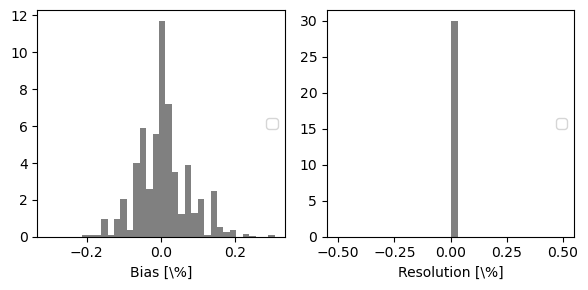

In [11]:
fig, (axs, ax1) = plt.subplots(1, 2, figsize=(6, 3))
nbins = 30
count, bins, ignored = axs.hist(bias_N[:, 0], nbins, density=True, color="grey")

axs.set_xlabel("Bias [\\%]")
axs.legend(loc="center right")

x = axs.get_xlim()
mu = 0
axs.set_xlim(mu - np.max(np.abs(x)), mu + np.max(np.abs(x)))

count, bins, ignored = ax1.hist(resolution_N[:, 0], nbins, density=True, color="grey")

ax1.set_xlabel("Resolution [\\%]")
# ax1.set_title(f"N = {N}")
ax1.legend(loc="center right")

x = ax1.get_xlim()
ax1.set_xlim(mu - np.max(np.abs(x)), mu + np.max(np.abs(x)))
plt.tight_layout()

print(f"Bias error: {np.mean(bias_N[:,1]):.3} pm {np.std(bias_N[:,1]):.3}")
print(
    f"Resolution error: {np.mean(resolution_N[:,1]):.3} pm {np.std(resolution_N[:,1]):.3}"
)

In [12]:
valuies_asimov = [
    [
        1,  # dataset_asimov.models[1].parameters['norm'].value,
        0,
    ],  # dataset_asimov.models[1].parameters['norm'].error],
    [
        dataset_asimov.models[0].parameters["amplitude"].value,
        dataset_asimov.models[0].parameters["amplitude"].error,
    ],
    [
        dataset_asimov.models[0].parameters["index"].value,
        dataset_asimov.models[0].parameters["index"].error,
    ],
    [
        dataset_asimov.models[0].parameters["lambda_"].value,
        dataset_asimov.models[0].parameters["lambda_"].error,
    ],
]


valuies_asimov_N = [
    [
        dataset_asimov_N.models.parameters["norm"].value,
        dataset_asimov_N.models.parameters["norm"].error,
    ],
    [
        dataset_asimov_N.models.parameters["amplitude"].value,
        dataset_asimov_N.models.parameters["amplitude"].error,
    ],
    [
        dataset_asimov_N.models.parameters["index"].value,
        dataset_asimov_N.models.parameters["index"].error,
    ],
    [
        dataset_asimov_N.models.parameters["lambda_"].value,
        dataset_asimov_N.models.parameters["lambda_"].error,
    ],
]
print(valuies_asimov_N)

[[1.000004044215729, 0.0015702156529688548], [1.0003705246158278e-11, 1.2489703010121209e-13], [2.304645130326782, 0.025835514156183688], [0.01596085292244244, 0.00432263714260435]]


In [13]:
# std best fit, nui best fit, ...
within_norm = [
    fraction_within(
        valuies_asimov[0][0] - valuies_asimov[0][1],
        valuies_asimov[0][0] + valuies_asimov[0][1],
        norms,
    ),
    fraction_within(
        valuies_asimov_N[0][0] - valuies_asimov_N[0][1],
        valuies_asimov_N[0][0] + valuies_asimov_N[0][1],
        norms,
    ),
]

within_amplitude = [
    fraction_within(
        valuies_asimov[1][0] - valuies_asimov[1][1],
        valuies_asimov[1][0] + valuies_asimov[1][1],
        amplitudes,
    ),
    fraction_within(
        valuies_asimov_N[1][0] - valuies_asimov_N[1][1],
        valuies_asimov_N[1][0] + valuies_asimov_N[1][1],
        amplitudes,
    ),
]

within_index = [
    fraction_within(
        valuies_asimov[2][0] - valuies_asimov[2][1],
        valuies_asimov[2][0] + valuies_asimov[2][1],
        indices,
    ),
    fraction_within(
        valuies_asimov_N[2][0] - valuies_asimov_N[2][1],
        valuies_asimov_N[2][0] + valuies_asimov_N[2][1],
        indices,
    ),
]

withins = [within_norm, within_amplitude, within_index]
print(withins)

mask = dataset_asimov.mask.data.sum(axis=2).sum(axis=1) > 0
ebins = dataset_asimov.counts.geom.axes[0].center[mask]
asimov, asimov_errors = dataset_asimov.models[0].spectral_model.evaluate_error(ebins)
asimov_N, asimov_errors_N = dataset_asimov_N.models[0].spectral_model.evaluate_error(
    ebins
)

withine = []
withine_N = []

for ie, e in enumerate(ebins):
    xs = []
    xs_N = []
    for f in flux:
        value = f[ie]
        lowerlim = np.all(value <= asimov.value[ie] + asimov_errors.value[ie])
        upperlim = np.all(value >= asimov.value[ie] - asimov_errors.value[ie])
        x = lowerlim & upperlim
        xs.append(x)

        lowerlim = np.all(value <= asimov_N.value[ie] + asimov_errors_N.value[ie])
        upperlim = np.all(value >= asimov_N.value[ie] - asimov_errors_N.value[ie])
        x = lowerlim & upperlim
        xs_N.append(x)

    withine.append(np.count_nonzero(xs) / N)
    withine_N.append(np.count_nonzero(xs_N) / N)

[[0.0, 0.69], [0.0, 0.0], [0.091, 0.135]]


# Likelihood Contours Amplitude - Index

In [14]:
def compute_fraction(amplitudes_data, indices_data, ax1, ax2, note = "",
                    ylabel = "amplitude", xlabel = "index"):
    data_N_new, (abins, ibins) = np.histogramdd(
        (amplitudes_data, indices_data), (amplitude_bin, index_bin)
    )
    d_N = (data_contour_N < (1 + data_contour_N.min())).reshape(np.shape(data_contour_N))
    d = (data_contour < (1 + data_contour.min())).reshape(np.shape(data_contour))
    fraction = np.sum(data_N_new * d) / N * 100
    fraction_N = np.sum(data_N_new * d_N) / N * 100

    data_N_new, (abins, ibins) = np.histogramdd(
        (amplitudes_data, indices_data), (amplitude_bin, index_bin)
    )

    im = ax1.pcolormesh(ibins, abins, data_N_new * d)
    im = ax2.pcolormesh(ibins, abins, data_N_new * d_N)

    for ax in (ax1, ax2):
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        plot_contour(ax,  indexy__new_N, amplix__new_N, data_contour, color = 'white')
        plot_contour(ax,  indexy__new_N, amplix__new_N, data_contour_N, color = 'orange')

    ax1.set_title(f"Within $1\\sigma$ : {fraction:.3} \\% {note}")
    ax2.set_title(f"Within $1\\sigma$ Nuisance: {fraction_N:.3} \\% {note}")
    

In [15]:
a_unit = ""

/tmp/ipykernel_5841/2221281249.py:727: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interp2d(
/tmp/ipykernel_5841/2221281249.py:735: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolat

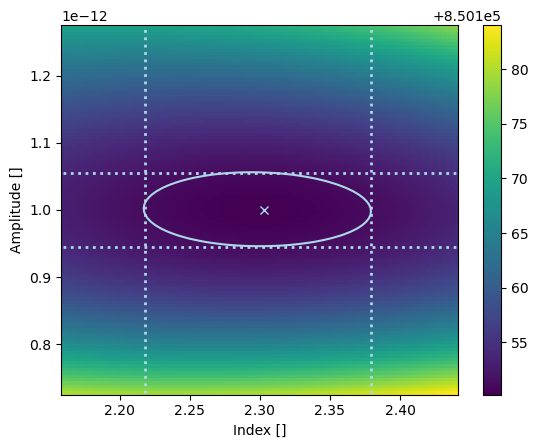

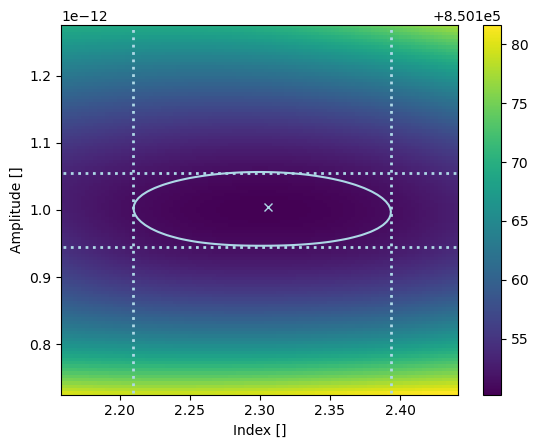

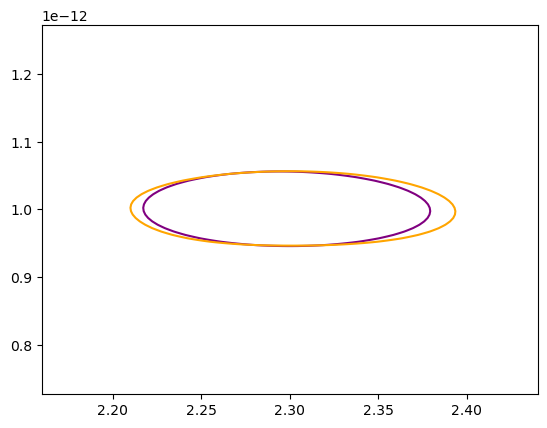

In [16]:
data_contour, indexy__new, amplix__new , tupel = show_contour(name = "index_amplitude_")
ampli_min_asimov,ampli_max_asimov,index_min_asimov,index_max_asimov,ampli_best_asimov,index_best_asimov = tupel 

data_contour_N, indexy__new_N, amplix__new_N , tupel = show_contour(name = "index_amplitude_N")
ampli_min_asimov_N,ampli_max_asimov_N,index_min_asimov_N,index_max_asimov_N,ampli_best_asimov_N,index_best_asimov_N = tupel 

fig, ax = plt.subplots()
plot_contour(ax,  indexy__new_N, amplix__new_N, data_contour, color = 'purple')
plot_contour(ax,  indexy__new_N, amplix__new_N, data_contour_N, color = 'orange')

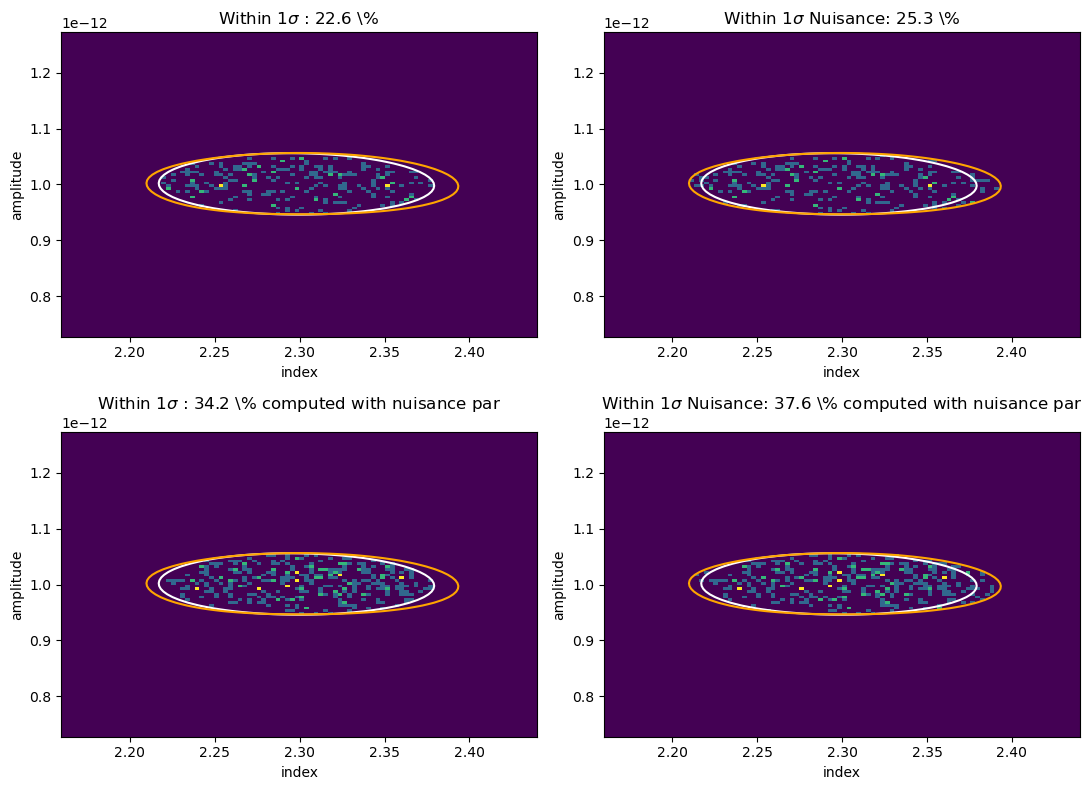

In [17]:
N_new = 110
N_new_y = 100

N_bins = N_new + 1
N_bins_y = N_new_y + 1

amplitude_bin = np.linspace(amplix__new_N[0], amplix__new_N[-1], N_bins)
index_bin = np.linspace(indexy__new_N[0], indexy__new_N[-1], N_bins_y)

amplitudes_data = valuies[1][:, 0]
indices_data = valuies[2][:, 0]

amplitudes_data_N = valuies_N[1][:, 0]
indices_data_N = valuies_N[2][:, 0]

fig,axs = plt.subplots(2, 2, figsize=(11, 8))


compute_fraction(amplitudes_data, indices_data, axs[0][0], axs[0][1])
compute_fraction(amplitudes_data_N, indices_data_N, axs[1][0], axs[1][1], note = "computed with nuisance par")
plt.tight_layout()

## Index- Lambda

/tmp/ipykernel_5841/2221281249.py:727: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interp2d(
/tmp/ipykernel_5841/2221281249.py:735: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolat

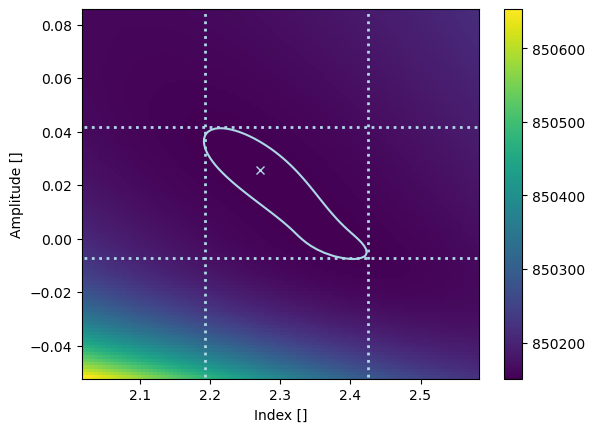

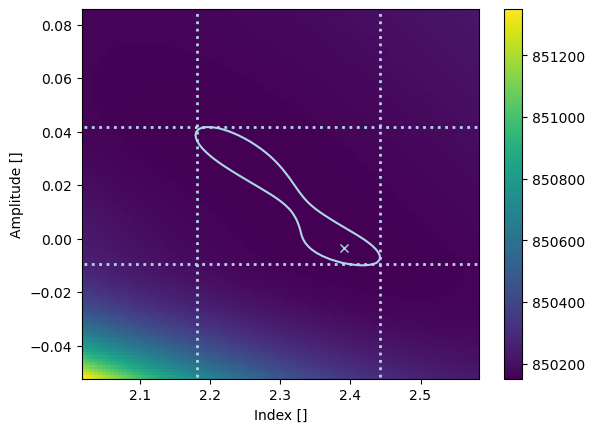

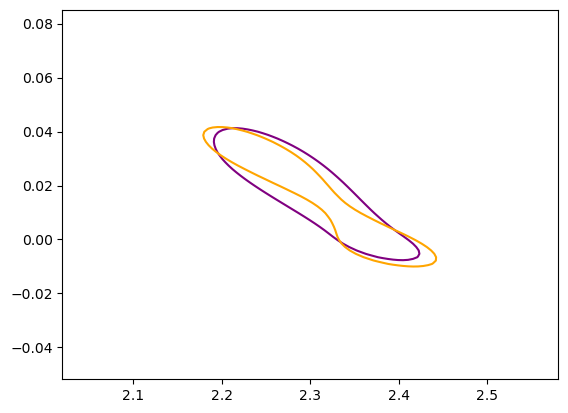

In [18]:
data_contour, indexy__new, amplix__new , tupel = show_contour(name = "lambda__index_")
ampli_min_asimov,ampli_max_asimov,index_min_asimov,index_max_asimov,ampli_best_asimov,index_best_asimov = tupel 

data_contour_N, indexy__new_N, amplix__new_N , tupel = show_contour(name = "lambda__index_N")
ampli_min_asimov_N,ampli_max_asimov_N,index_min_asimov_N,index_max_asimov_N,ampli_best_asimov_N,index_best_asimov_N = tupel 

fig, ax = plt.subplots()
plot_contour(ax,  indexy__new_N, amplix__new_N, data_contour, color = 'purple')
plot_contour(ax,  indexy__new_N, amplix__new_N, data_contour_N, color = 'orange')

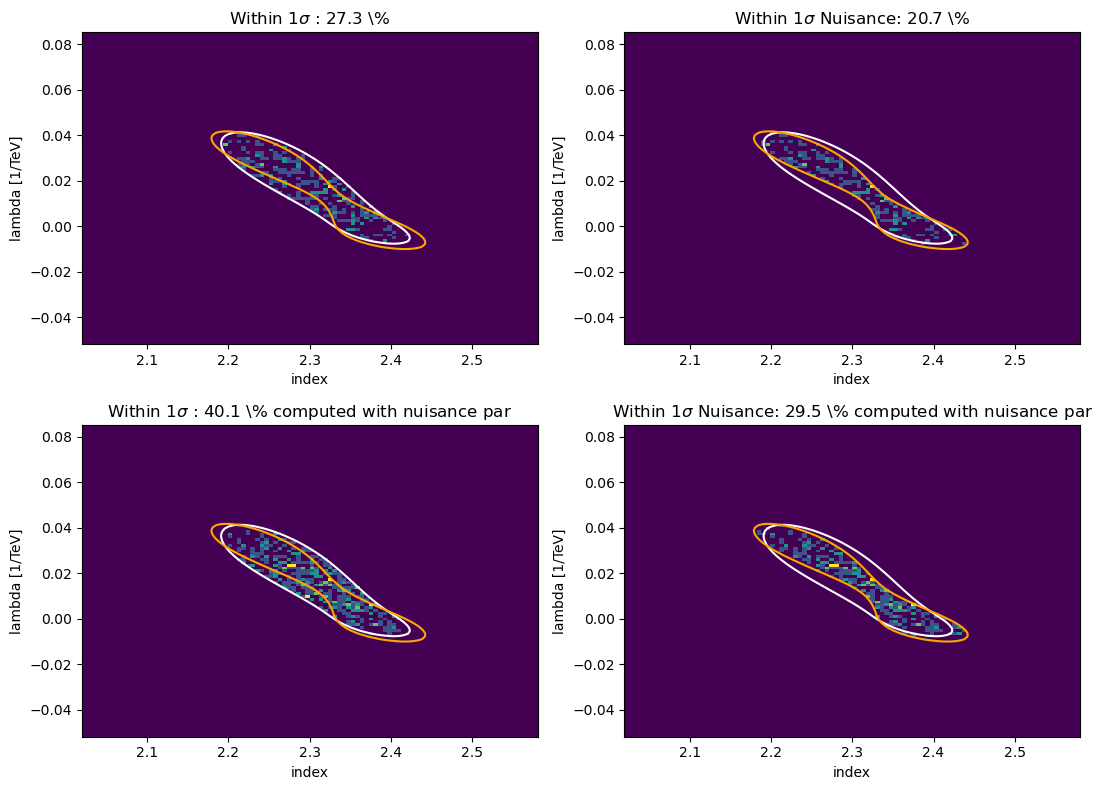

In [19]:
N_new = 110
N_new_y = 100

N_bins = N_new + 1
N_bins_y = N_new_y + 1

amplitude_bin = np.linspace(amplix__new_N[0], amplix__new_N[-1], N_bins)
index_bin = np.linspace(indexy__new_N[0], indexy__new_N[-1], N_bins_y)

amplitudes_data = valuies[3][:, 0]
indices_data = valuies[2][:, 0]

amplitudes_data_N = valuies_N[3][:, 0]
indices_data_N = valuies_N[2][:, 0]

fig,axs = plt.subplots(2, 2, figsize=(11, 8))


compute_fraction(amplitudes_data, indices_data, axs[0][0], axs[0][1],
                 xlabel = 'index', ylabel = 'lambda [1/TeV]')
compute_fraction(amplitudes_data_N, indices_data_N, axs[1][0], axs[1][1], note = "computed with nuisance par",
                xlabel = 'index', ylabel = 'lambda [1/TeV]')
plt.tight_layout()

## Amplitude Lambda

/tmp/ipykernel_5841/2221281249.py:727: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interp2d(
/tmp/ipykernel_5841/2221281249.py:735: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolat

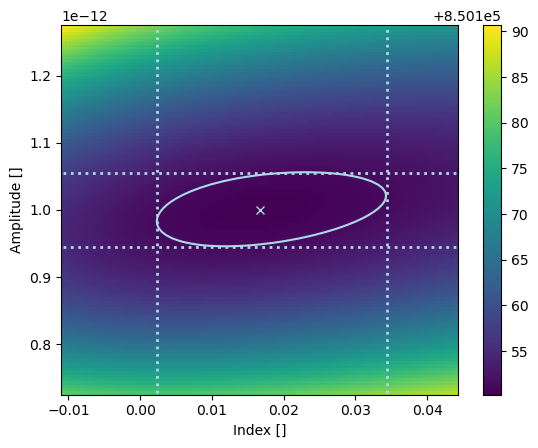

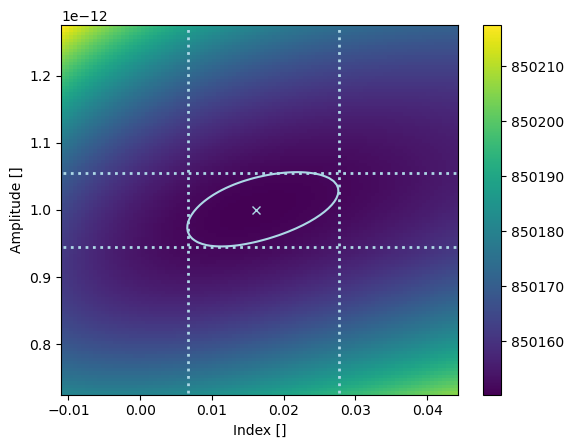

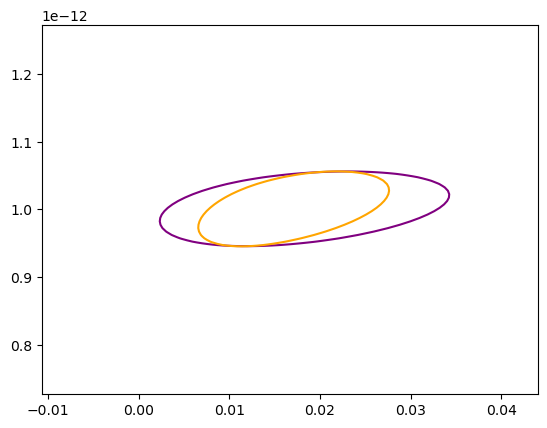

In [20]:
data_contour, indexy__new, amplix__new , tupel = show_contour(name = "lambda__amplitude_")
ampli_min_asimov,ampli_max_asimov,index_min_asimov,index_max_asimov,ampli_best_asimov,index_best_asimov = tupel 

data_contour_N, indexy__new_N, amplix__new_N , tupel = show_contour(name = "lambda__amplitude_N")
ampli_min_asimov_N,ampli_max_asimov_N,index_min_asimov_N,index_max_asimov_N,ampli_best_asimov_N,index_best_asimov_N = tupel 

fig, ax = plt.subplots()
plot_contour(ax,  indexy__new_N, amplix__new_N, data_contour, color = 'purple')
plot_contour(ax,  indexy__new_N, amplix__new_N, data_contour_N, color = 'orange')

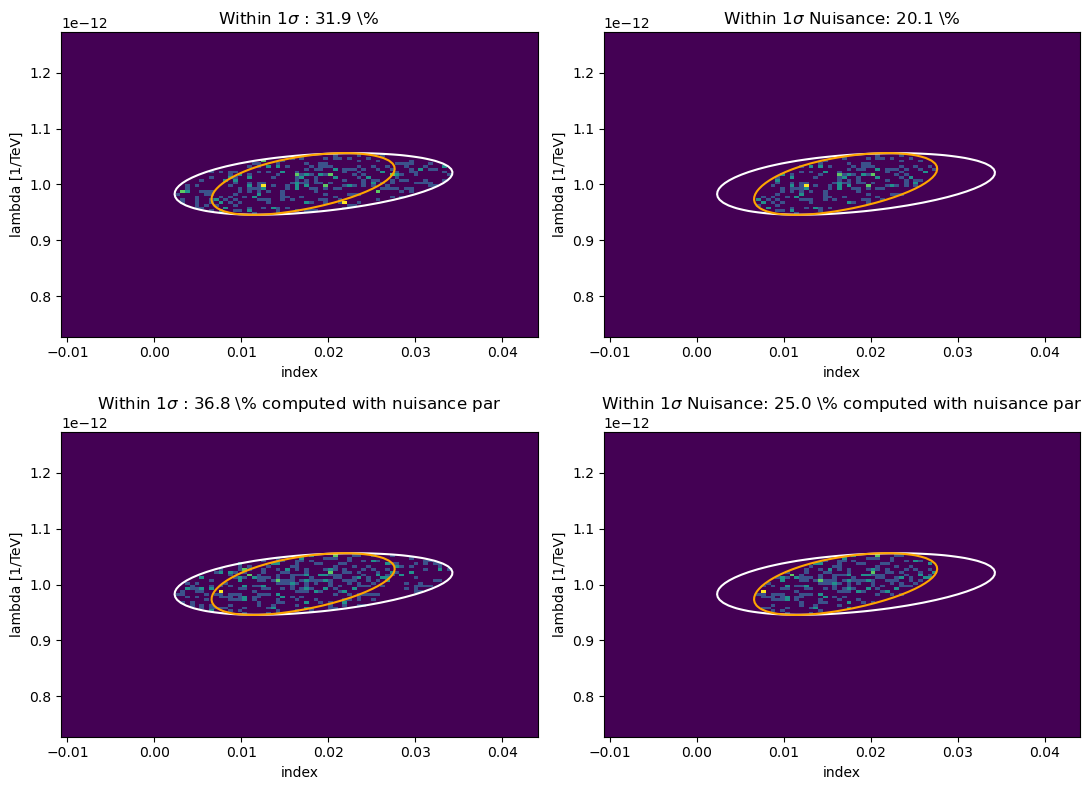

In [21]:
N_new = 110
N_new_y = 100

N_bins = N_new + 1
N_bins_y = N_new_y + 1

amplitude_bin = np.linspace(amplix__new_N[0], amplix__new_N[-1], N_bins)
index_bin = np.linspace(indexy__new_N[0], indexy__new_N[-1], N_bins_y)

amplitudes_data = valuies[1][:, 0]
indices_data = valuies[3][:, 0]

amplitudes_data_N = valuies_N[1][:, 0]
indices_data_N = valuies_N[3][:, 0]

fig,axs = plt.subplots(2, 2, figsize=(11, 8))


compute_fraction(amplitudes_data, indices_data, axs[0][0], axs[0][1],
                 xlabel = 'index', ylabel = 'lambda [1/TeV]')
compute_fraction(amplitudes_data_N, indices_data_N, axs[1][0], axs[1][1], note = "computed with nuisance par",
                xlabel = 'index', ylabel = 'lambda [1/TeV]')
plt.tight_layout()

# End Plots

## Colors

In [22]:
import seaborn as sns

s = sns.color_palette("Paired")
s

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [24]:
blue = "mediumblue", s[0]  # dark, light
green = s[3], s[2]
red = s[5], s[4]
orange = s[7], s[6]
purple = s[9], s[8]

print(s[0])

(0.6509803921568628, 0.807843137254902, 0.8901960784313725)


In [25]:
config = Dataset_load.load_config()
colors = config["colors"]["one"]

# asimov, asimov+nui, error asimov, error asimov+nui

a1 = blue
a2 = red
colors = [a1[0], a2[0], a1[1], a2[1]]

# rnd, rnd_example, error rnd_example, rnd+nui, rnd_example+nui, error rnd_example+nui
r1 = orange
r2 = purple
colors_rnd = [r1[0], r1[0], r1[0], r2[0], r2[0], r2[0]]

(
    color_rnd,
    color_rnd_example,
    color_rnd_err,
    color_rnd_nui,
    color_rnd_nui_example,
    color_rnd_nui_err,
) = colors_rnd
cc = color_rnd_example

alpha_nui = 0.99
alpha_st = 0.99
legendsscatter = ["Asimov w/o nui.", "Asimov with nui."]
legends = ["", ""]

alpha_rnd = 0.2
alpha_rnd_nui = 0.2

nbins = 20

## Asimov Plots

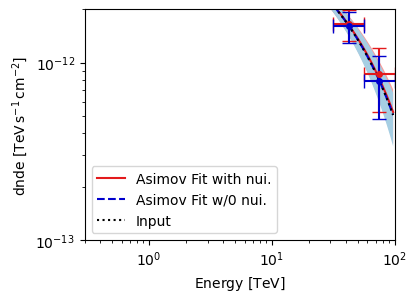

In [26]:
fp_asimov = FluxPointsDataset(data = FluxPoints.read("data/fluxpoints/2_fluxpoints_asimov.fits"),
                             models = Models.read("data/fluxpoints/2_model_asimov.fits"))
fp_asimov_N = FluxPointsDataset(data = FluxPoints.read("data/fluxpoints/2_fluxpoints_asimov_N.fits"),
                             models = Models.read("data/fluxpoints/2_model_asimov_N.fits"))

def compute_precision(N):
    Z = 1.645
    return Z / np.sqrt(N)


energy_power = 2
fig, axs = plt.subplots(1, 1, figsize=(4, 3))
plot_asimov_spectrum(fig, axs)
fp_asimov_N.data.plot(energy_power=2, color=colors[1], ax=axs, capsize = 5)
fp_asimov.data.plot(energy_power=2, color=colors[0], ax=axs, capsize = 5)

axs.set_xlim(0.3, 100)
fig.savefig("plots/7c_asimov.pdf", bbox_inches="tight")
fig.savefig("plots/7c_asimov.png", bbox_inches="tight")

(0.3, 100)

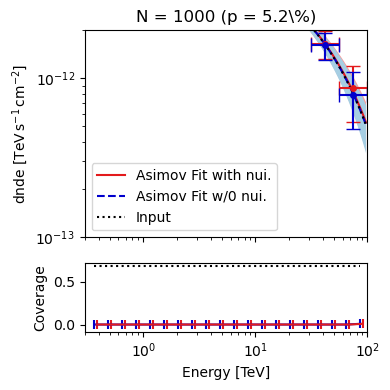

In [27]:
ebins = dataset_asimov.geoms['geom'].axes[0].center.value[4:]
energy_power = 2
fig, (axs, ax2) = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True, figsize=((4, 4))
)
plot_asimov_spectrum(fig, axs)
fp_asimov_N.data.plot(energy_power=2, color=colors[1], ax=axs, capsize = 5)
fp_asimov.data.plot(energy_power=2, color=colors[0], ax=axs, capsize = 5)
plot_coverage(fig, ax2)
axs.set_xlim(0.3, 100)

## RND Plots

In [28]:
shift_rnd = 0.0324452
tilt_rnd = 0.0


fluxpoints = FluxPoints.read(
    f"data/fluxpoints/6P_fluxpoints_{shift_rnd:.6}_{tilt_rnd:.6}.fits"
)
fluxpoints_N = FluxPoints.read(
    f"data/fluxpoints/6P_fluxpoints_N_{shift_rnd:.6}_{tilt_rnd:.6}.fits"
)
model_name = f"data/fluxpoints/6P_model_N_{shift_rnd:.6}_{tilt_rnd:.6}.yaml"
fluxpoints_Nds = FluxPointsDataset(data=fluxpoints_N, models=Models.read(model_name))
model_name = f"data/fluxpoints/6P_model_{shift_rnd:.6}_{tilt_rnd:.6}.yaml"
fluxpoints_ds = FluxPointsDataset(data=fluxpoints, models=Models.read(model_name))
shift = bias
fig, (axs, ax1) = plt.subplots(1, 2, figsize=(5, 2.4))
plot_rnd_fistribution(fig, (axs, ax1), cc)

if savefig:
    fig.savefig(f"plots/7c_rnd_sys_{shift}." + picformat)
    fig.savefig(f"plots/7c_rnd_sys_{shift}.pdf")

FileNotFoundError: [Errno 2] No such file or directory: 'data/fluxpoints/6P_fluxpoints_0.0324452_0.0.fits'

In [ ]:
bias_rnds = [ 0.00449747, -0.00707373, -0.00855279, 0.0124968, 0.0147678, 0.0200569, 0.0269915, -0.0294929, -0.029697, 0.0324452, 0.052114, 0.0521778,
             -0.0571675, -0.0686547, 0.0700624, -0.075319, -0.0775149, -0.0798116, -0.0825988, -0.0851904, 0.0883529, -0.0905852,
             -0.101136, -0.102357, 0.103006, -0.103276, -0.10798, 0.110638, -0.119321, 0.126377, 0.128006, 0.130151, -0.16968, 
             -0.204605, -0.206881  ]

bias_rnds = [  0.0521778,-0.0571675,  -0.0686547,  -0.103276, 0.130151 ]
bias_rnds = [  -0.0571675, ]

for shift_rnd in  (bias_rnds):
    print(shift_rnd)
    tilt_rnd = 0.0
    fluxpoints = FluxPoints.read(
        f"data/fluxpoints/6P_fluxpoints_{shift_rnd:.6}_{tilt_rnd:.6}.fits"
    )
    fluxpoints_N = FluxPoints.read(
        f"data/fluxpoints/6P_fluxpoints_N_{shift_rnd:.6}_{tilt_rnd:.6}.fits"
    )
    model_name = f"data/fluxpoints/6P_model_N_{shift_rnd:.6}_{tilt_rnd:.6}.yaml"
    fluxpoints_Nds = FluxPointsDataset(data=fluxpoints_N, models=Models.read(model_name))
    model_name = f"data/fluxpoints/6P_model_{shift_rnd:.6}_{tilt_rnd:.6}.yaml"
    fluxpoints_ds = FluxPointsDataset(data=fluxpoints, models=Models.read(model_name))
   
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    plot_choice_sed(fig, ax)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_choice_sed(fig, ax)
fig.savefig("plots/7c_fluxpoint_example.pdf", bbox_inches="tight")
fig.savefig("plots/7c_fluxpoint_example.png", bbox_inches="tight")

## Input Within Rnd Results

In [ ]:
a_within, i_within, l_within = [], [], []
a_within_N, i_within_N , l_within_N = [], [], []

a_input = dataset_asimov.models.parameters["amplitude"].value
i_input = dataset_asimov.models.parameters["index"].value
l_input = dataset_asimov.models.parameters["lambda_"].value


for a_ in amplitudes:
    a_within.append(((a_[0] - a_[1]) <= a_input) and ((a_[0] + a_[1]) >= a_input))
for i_ in indices:
    i_within.append(((i_[0] - i_[1]) <= i_input) and ((i_[0] + i_[1]) >= i_input))
for i_ in lambdas:
    l_within.append(((i_[0] - i_[1]) <= l_input) and ((i_[0] + i_[1]) >= l_input))
    
for a_ in amplitudes_N:
    a_within_N.append(((a_[0] - a_[1]) <= a_input) and ((a_[0] + a_[1]) >= a_input))
for i_ in indices_N:
    i_within_N.append(((i_[0] - i_[1]) <= i_input) and ((i_[0] + i_[1]) >= i_input))
for a_ in lambdas_N:
    l_within_N.append(((a_[0] - a_[1]) <= l_input) and ((a_[0] + a_[1]) >= l_input))



In [ ]:
fr_a = sum(a_within) / len(a_within)
print(fr_a)
fr_i = sum(i_within) / len(i_within)
print(fr_i)
fr_l = sum(l_within) / len(l_within)
print(fr_l)

In [ ]:
fr_N_a = sum(a_within_N) / len(a_within_N)
print(fr_N_a)
fr_N_i = sum(i_within_N) / len(i_within_N)
print(fr_N_i)
fr_N_l = sum(l_within_N) / len(l_within_N)
print(fr_N_l)

In [ ]:

    
alpha_rnd_nui = alpha_rnd= 0.1
factor_ampli = 1#e-12
factor_ampli_inv = 1e12
factor_lambda = 0.01
ampl_range = [0.7, 1.3]
index_range = [1.9,2.7]
lambda_range = [1/60 - 0.06, 1/60 + 0.06]

alpha = 0.6
nnbins = 30
fig, ax = plt.subplots(3,1, figsize = (4,5))
plot_all_histo(ax)

fig.savefig("plots/7c_rnd_par_dist.pdf", bbox_inches="tight")
fig.savefig("plots/7c_rnd_par_dist.png", bbox_inches="tight")

In [ ]:



y2 = 2
fig, axs = plt.subplots(
    2,
    2,
    gridspec_kw={"height_ratios": [3, 3], "width_ratios": [3, 3]},sharex='col' , sharey='row' , 
    figsize=(5.0, 5.0),
)
axs_1 = axs[1][0]
axs_2 = axs[0][0]
axs_3 = axs[1][1]
axs[0, -1].axis("off")


plot_scatter_3times(axs_1, axs_2, axs_3)


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.02, 
                    hspace=0.02)
axs_2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig("plots/7c_scatter.pdf", bbox_inches="tight")
fig.savefig("plots/7c_scatter.png", bbox_inches="tight")

In [ ]:
alpha_rnd_nui = alpha_rnd= 0.1
factor_ampli = 1#e-12
factor_ampli_inv = 1e12
factor_lambda = 0.01
ampl_range = [0.7, 1.3]
index_range = [1.9,2.7]
lambda_range = [-0.05, 0.09]


y2 = 2
fig3 = plt.figure( figsize = (7,6))
gs = fig3.add_gridspec(5, 5)
ax_a = fig3.add_subplot(gs[0, 0:2])
axs_2 = fig3.add_subplot(gs[1:3, 0:2])
axs_1 = fig3.add_subplot(gs[3:5, 0:2])

ax_c = fig3.add_subplot(gs[2:3,  2:4])
axs_3 = fig3.add_subplot(gs[3:5,  2:4])
ax_b = fig3.add_subplot(gs[3:5,  4:5])

plot_scatter_3times(axs_1, axs_2, axs_3)



nbins = np.linspace(ampl_range[0], ampl_range[1],nnbins )
a, bins, _= ax_b.hist(amplitudes[:,0]*factor_ampli_inv, label = f"{fr_a*100:.3} \\%", bins = nbins,  color = color_rnd, alpha = alpha, orientation = 'horizontal')
ax_b.hist(amplitudes_N[:,0]*factor_ampli_inv, label = f"{fr_N_a*100:.3} \\%", bins = bins, color = color_rnd_nui, alpha = alpha, orientation = 'horizontal')
ax_b.hlines(1, 0, ax_b.get_xlim()[1], color = 'black', alpha = alpha)
ax_b.set_ylim(ampl_range[0], ampl_range[1])
ax_b.set_ylabel("Amplitude [1e-12/TeVcm2s]",)
ax_b.yaxis.set_label_position("right")
ax_b.yaxis.tick_right()
ax_b.tick_params(left = 0, labelleft  = 0,  right = 1,  labelright=1, bottom=1, labelbottom=False)

nbins = np.linspace(index_range[0], index_range[1],nnbins )
a, bins, _= ax_a.hist(indices[:,0], label = f"{fr_i*100:.3} \\%", bins = nbins, color = color_rnd, alpha = alpha)
ax_a.hist(indices_N[:,0], label = f"{fr_N_i*100:.3} \\%",  bins = bins, color = color_rnd_nui, alpha = alpha)
ax_a.vlines(2.3, 0, ax_a.get_ylim()[1], color = 'black', alpha = alpha)
ax_a.set_xlim(index_range[0], index_range[1])
ax_a.tick_params(top=True, labeltop=1, bottom=1, labelbottom=False)
ax_a.set_xlabel("Index []")
ax_a.xaxis.set_label_position("top")
axs_2.set_xlabel("")
axs_2.tick_params(top = 0, labeltop  = 0, )


nbins = np.linspace(lambda_range[0], lambda_range[1],nnbins )
a, bins, _= ax_c.hist(lambdas[:,0], label = f"{fr_l*100:.3} \\%", bins = nbins, color = color_rnd, alpha = alpha)
ax_c.hist(lambdas_N[:,0], label = f"{fr_N_l*100:.3} \\%",  bins = bins, color = color_rnd_nui, alpha = alpha)
ax_c.vlines(1/60, 0, ax_c.get_ylim()[1], color = 'black', alpha = alpha)
ax_c.set_xlim(lambda_range[0], lambda_range[1])
ax_c.set_xlabel("1 /Cutoff [1/TeV]")
ax_c.tick_params(left = 0, labelleft  = 0,  top = 1,  labeltop=1, bottom=1, labelbottom=False)
ax_c.set_xlabel("Lambda [1/TeV]")
ax_c.xaxis.set_label_position("top")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.1)

for a in [ax_a, ax_b, ax_c]:
    legend = a.legend(title = "Containig Input:", fontsize = 8)
    plt.setp(legend.get_title(),fontsize='xx-small')
    
fig3.savefig("plots/7c_scatter_complicated.pdf", bbox_inches="tight")
fig3.savefig("plots/7c_scatter_complicated.png", bbox_inches="tight")

In [ ]:
alpha = 0.7
nnbins = 30
fig, ax = plt.subplots(3,2, figsize = (9,3*5))
ax = ax.flatten()
nbins = np.linspace(ampl_range[0], ampl_range[1],nnbins )
i =0 
for a_ in amplitudes[:100]:
    within = ((a_[0] - a_[1]) <= a_input) and ((a_[0] + a_[1]) >= a_input)
    if within:
        col = color_rnd
    else:
        col = 'red'
    ax[0].errorbar(x = a_[0], y = i , xerr = a_[1],  color = col, fmt='x')
    i +=1
    
i = 0    
for a_ in amplitudes_N[:100]:
    within = ((a_[0] - a_[1]) <= a_input) and ((a_[0] + a_[1]) >= a_input)
    if within:
        col = color_rnd_nui
    else:
        col = 'red'
    ax[1].errorbar(x = a_[0], y = i , xerr = a_[1],  color = col, fmt='x')
    i +=1

    
ax[0].vlines(1e-12, 0, ax[0].get_ylim()[1], color = 'black', alpha = alpha)
ax[1].vlines(1e-12, 0, ax[0].get_ylim()[1], color = 'black', alpha = alpha)
ax[0].set_xlim(ampl_range[0]*1e-12, ampl_range[1]*1e-12)
ax[1].set_xlim(ampl_range[0]*1e-12, ampl_range[1]*1e-12)
ax[0].set_xlabel("Amplitude [1/TeVcm2s]")
ax[1].set_xlabel("Amplitude [1/TeVcm2s]")

i =0 
for a_ in indices[:100]:
    within = ((a_[0] - a_[1]) <= i_input) and ((a_[0] + a_[1]) >= i_input)
    if within:
        col = color_rnd
    else:
        col = 'red'
    ax[2].errorbar(x = a_[0], y = i , xerr = a_[1],  color = col, fmt='x')
    i +=1
    
i = 0    
for a_ in indices_N[:100]:
    within = ((a_[0] - a_[1]) <= i_input) and ((a_[0] + a_[1]) >= i_input)
    if within:
        col = color_rnd_nui
    else:
        col = 'red'
    ax[3].errorbar(x = a_[0], y = i , xerr = a_[1],  color = col, fmt='x')
    i +=1

    
ax[2].vlines(2.3, 0, ax[0].get_ylim()[1], color = 'black', alpha = alpha)
ax[3].vlines(2.3, 0, ax[0].get_ylim()[1], color = 'black', alpha = alpha)
ax[2].set_xlim(index_range[0], index_range[1])
ax[3].set_xlim(index_range[0], index_range[1])
ax[2].set_xlabel("Index []")
ax[3].set_xlabel("Index []")


i =0 
for a_ in lambdas[:100]:
    within = ((a_[0] - a_[1]) <= l_input) and ((a_[0] + a_[1]) >= l_input)
    if within:
        col = color_rnd
    else:
        col = 'red'
    ax[4].errorbar(x = a_[0], y = i , xerr = a_[1],  color = col, fmt='x')
    i +=1
    
i = 0    
for a_ in lambdas_N[:100]:
    within = ((a_[0] - a_[1]) <= l_input) and ((a_[0] + a_[1]) >= l_input)
    if within:
        col = color_rnd_nui
    else:
        col = 'red'
    ax[5].errorbar(x = a_[0], y = i , xerr = a_[1],  color = col, fmt='x')
    i +=1

    
ax[4].vlines(1/60, 0, ax[0].get_ylim()[1], color = 'black', alpha = alpha)
ax[5].vlines(1/60, 0, ax[0].get_ylim()[1], color = 'black', alpha = alpha)
ax[4].set_xlim(lambda_range[0], lambda_range[1])
ax[5].set_xlim(lambda_range[0], lambda_range[1])
ax[4].set_xlabel("1 /Cutoff [1/TeV]")
ax[5].set_xlabel("1 /Cutoff [1/TeV]")

for a in ax:
    a.legend(title = "Containing Input\n Within Errors:", loc = 'lower right')
plt.tight_layout()